<a href="https://colab.research.google.com/github/jyma14/Seminario_IA_DDAC_CIDETEQ/blob/main/DEMO1_SeminarioIA_SIREN_for_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

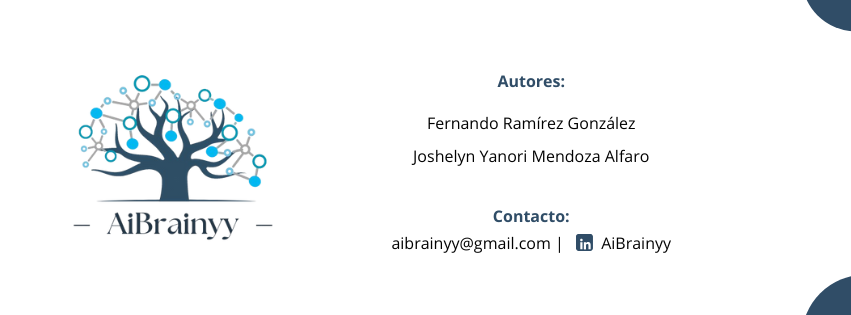

# DEMO 1. Use SIREN to model ODE systems.





In [1]:
# Import the necessary libraries for the project

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

#### Copy-Paste SIREN from the original work

In [4]:
class SineLayer(nn.Module):
    # This class implements a custom layer that applies a sine activation function.
    # Refer to paper section 3.2 and supplement section 1.5 for a detailed discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor that multiplies the activations before applying
    # the sine nonlinearity. This parameter is a hyperparameter and may vary for different signals in the first layer.

    # If is_first=False, the weights are divided by omega_0 to keep the activation magnitude constant,
    # while boosting gradients during backpropagation. This is explained in supplement section 1.5.

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        # Initialize the SineLayer class with input features, output features, bias option, and omega_0.
        super().__init__()

        self.omega_0 = omega_0  # Set the omega_0 (frequency factor).
        self.is_first = is_first  # Boolean to determine if it's the first layer or not.

        self.in_features = in_features  # Number of input features for the layer.
        self.linear = nn.Linear(in_features, out_features, bias=bias)  # Create a linear transformation.

        self.init_weights()  # Initialize the weights of the layer.

    def init_weights(self):
        # Initialize the weights of the layer. The initialization depends on whether it's the first layer or not.
        with torch.no_grad():  # Disable gradient tracking to prevent backpropagation during weight initialization.
            if self.is_first:
                # For the first layer, weights are uniformly initialized based on the input feature size.
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                # For layers after the first, initialize weights with a smaller range scaled by omega_0.
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        # Forward pass through the layer: apply the linear transformation and then the sine activation function.
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # This forward pass also returns the intermediate output (for visualization or analysis purposes).
        # It can be useful for examining the distribution of activations.
        intermediate = self.omega_0 * self.linear(input)  # Calculate the intermediate activations.
        return torch.sin(intermediate), intermediate  # Return both the final output and the intermediate activations.



In [5]:
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        # Initialize the Siren network.
        super().__init__()

        # Initialize an empty list to hold the layers of the network.
        self.net = []

        # First layer (SineLayer) with specific omega_0 for frequency scaling.
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        # Add hidden layers (SineLayers) with the specified omega_0 for each.
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        # Optionally add a linear output layer at the end (outermost layer).
        if outermost_linear:
            # If outermost_linear is True, use a standard linear layer instead of a sine activation.
            final_linear = nn.Linear(hidden_features, out_features)

            # Initialize the final linear layer's weights similarly to the SineLayer initialization.
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            # Add the final linear layer to the network.
            self.net.append(final_linear)
        else:
            # If outermost_linear is False, use a SineLayer for the final output.
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        # Convert the list of layers into a sequential model.
        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        # Forward pass for the Siren network.
        coords = coords.clone().detach().requires_grad_(True)  # Detach input and allow derivatives w.r.t input.
        output = self.net(coords)  # Pass the input through the layers of the network.
        return output, coords  # Return the output and the input coordinates for gradient calculations.

    def forward_with_activations(self, coords, retain_grad=False):
        '''
        Forward pass that also returns intermediate activations.
        This is useful for visualizing intermediate layer outputs.
        '''
        activations = OrderedDict()  # Initialize a dictionary to store activations.

        activation_count = 0  # Counter to keep track of activation layers.
        x = coords.clone().detach().requires_grad_(True)  # Clone input and allow derivatives.
        activations['input'] = x  # Store the initial input coordinates.

        # Iterate through the layers in the network.
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                # For SineLayers, we get the intermediate activations.
                x, intermed = layer.forward_with_intermediate(x)

                # Optionally retain gradients if required (useful for visualization).
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                # Store the intermediate activations in the dictionary.
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                # For linear layers, simply pass the input through.
                x = layer(x)

                # Optionally retain gradients.
                if retain_grad:
                    x.retain_grad()

            # Store the final output of each layer.
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        # Return all the activations (input, intermediate, and final outputs).
        return activations


In [6]:
def gradient(y, x, grad_outputs=None):
    # This function computes the gradient of y with respect to x using PyTorch's autograd.
    # It allows the calculation of gradients for further analysis, e.g., optimization or visualization.
    # If grad_outputs is not provided, set it to a tensor of ones with the same shape as y.
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)  # Default behavior: compute the gradient for each element of y.
        grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
      # Return the computed gradient.
    return grad


#### Code up the Lorenz system

\begin{equation}
  \begin{split}
    \frac{dx}{dt} & = \sigma (y-x) \\
    \frac{dy}{dt} & = x(\rho-z) - y \\
    \frac{dz}{dt} & = xy - \beta z
  \end{split}
\end{equation}

where $\sigma = 10, \rho = 28, \beta = 8/3$. \\
Initial condition: $(-8, 7, 27)$

In [7]:
# Generate simulation data using the Lorenz system
# Number of time steps and total simulation time.
n = 1000  # Number of time steps for the simulation
T = 10    # Total time for the simulation

# Create time steps (equally spaced values from 0 to T).
ts = np.linspace(0, T, n)  # Generate time steps from 0 to T, with 'n' equally spaced points.

# Define training set size (70% of the total data).
ntrain = int(n * 0.7)  # 70% of the data will be used for training.
train_ts = ts[:ntrain]  # Time steps for the training data (first 70% of the time steps).

# Lorenz system parameters
sigma = 10  # Prandtl number (controls the velocity of fluid flow)
rho = 28    # Rayleigh number (affects the heat transfer in the fluid)
beta = 8 / 3  # Geometric factor (relates to the aspect ratio of the convection cells)

# Define the Lorenz system's right-hand side (derivatives) as a function
def lorenz_rhs(x):
    # x is a vector [x, y, z], and the function returns the derivatives of the Lorenz system.
    return np.array([
        sigma * (x[1] - x[0]),  # dx/dt = sigma * (y - x)
        x[0] * (rho - x[2]) - x[1],  # dy/dt = x * (rho - z) - y
        x[0] * x[1] - beta * x[2]  # dz/dt = x * y - beta * z
    ])

# Initial conditions for the system (starting values of [x, y, z]).
x_init = [-8, 7, 27]  # Initial state of the system

# Solve the Lorenz system using the ode solver 'solve_ivp' from SciPy.
# This integrates the Lorenz system over time and returns the solution for each time step.
sol = integrate.solve_ivp(lambda _, x: lorenz_rhs(x), [0, T], x_init, t_eval=ts)

# Extract the solution (the values of x, y, z at each time step).
data = sol.y.T  # Transpose to get the shape (n, 3) where each row is [x, y, z] at a specific time.

# Split the data into training and testing sets.
train_data = data[:ntrain, :]  # Training data (first 70% of the data)

# Calculate the true gradients of x, y, and z based on the Lorenz system's equations.
x_grads_true = sigma * (train_data[:, 1] - train_data[:, 0])  # Gradient of x using the Lorenz equation for dx/dt.
y_grads_true = train_data[:, 0] * (rho - train_data[:, 2]) - train_data[:, 1]  # Gradient of y (dy/dt).
z_grads_true = train_data[:, 0] * train_data[:, 1] - beta * train_data[:, 2]  # Gradient of z (dz/dt).


In [8]:
# SIREN representation for state variables
x = Siren(in_features=1, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True).cuda()
y = Siren(in_features=1, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True).cuda()
z = Siren(in_features=1, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True).cuda()

Step 0, Total loss 255.363892, loss on grad 13541.125000


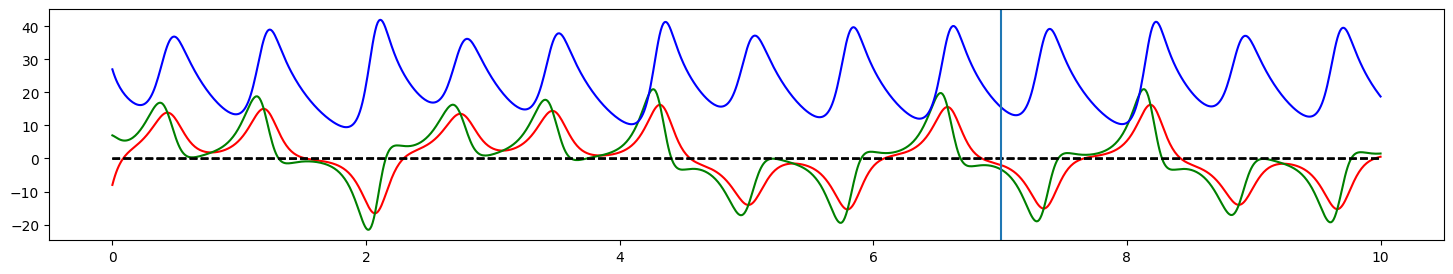

Step 2000, Total loss 4.937302, loss on grad 3581.359863


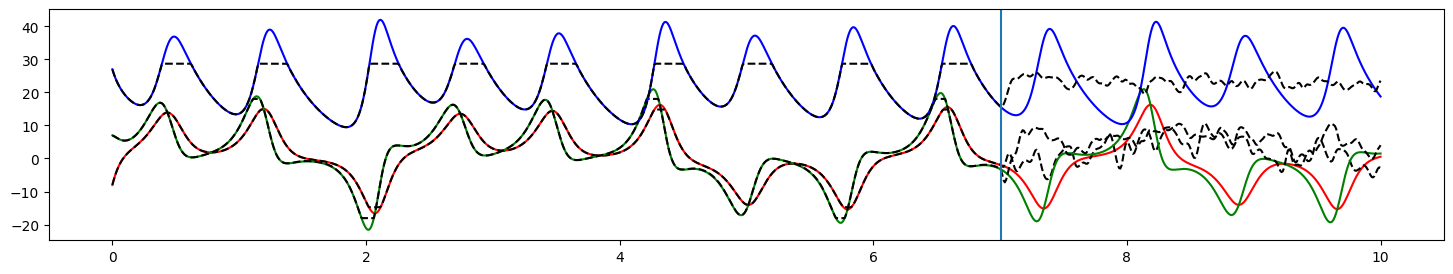

Step 4000, Total loss 0.208559, loss on grad 1318.755615


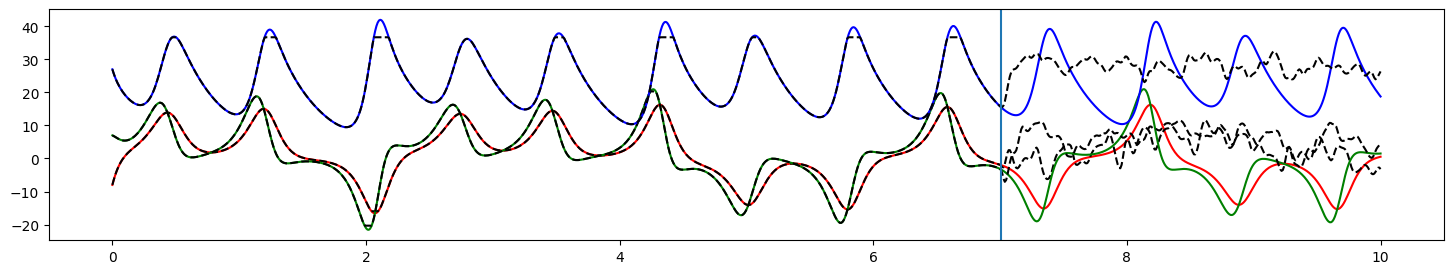

Step 6000, Total loss 0.020454, loss on grad 1554.101685


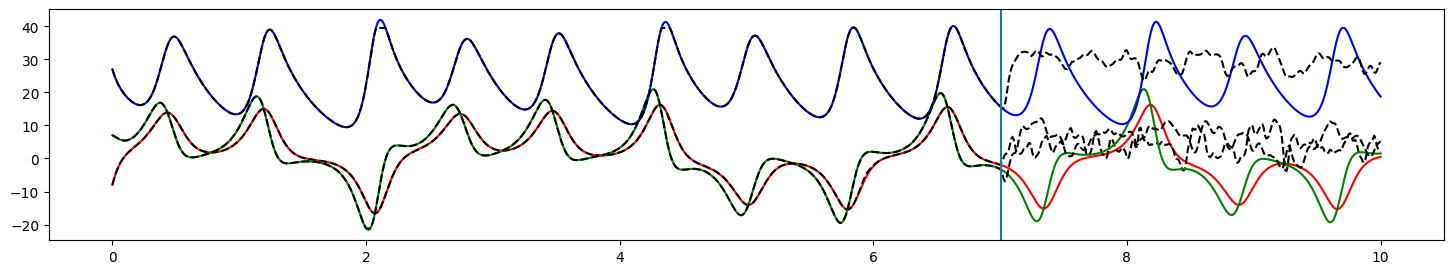

Step 8000, Total loss 0.000003, loss on grad 44046.136719


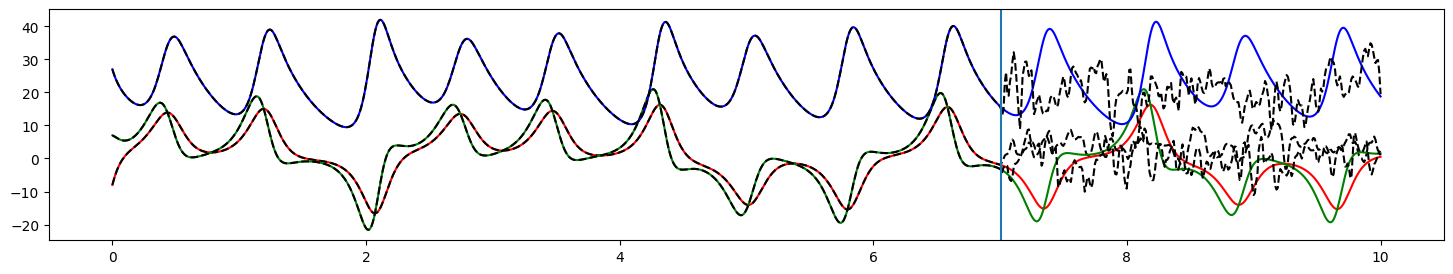

Step 10000, Total loss 0.000000, loss on grad 66861.039062


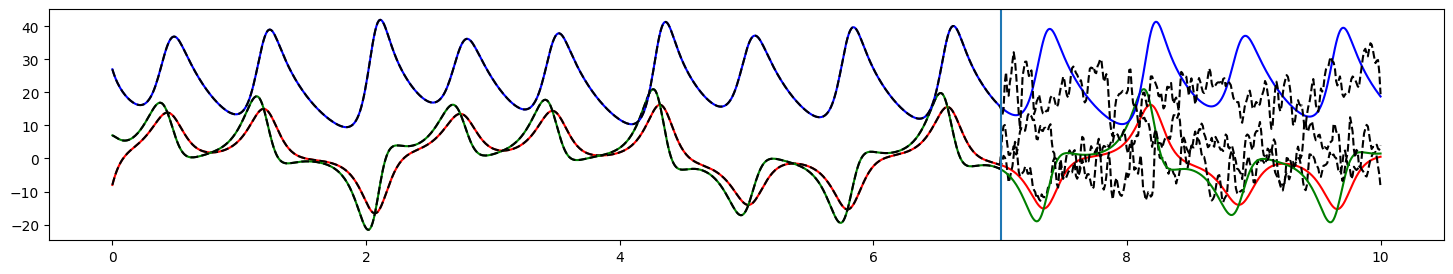

Step 12000, Total loss 0.000000, loss on grad 138736.796875


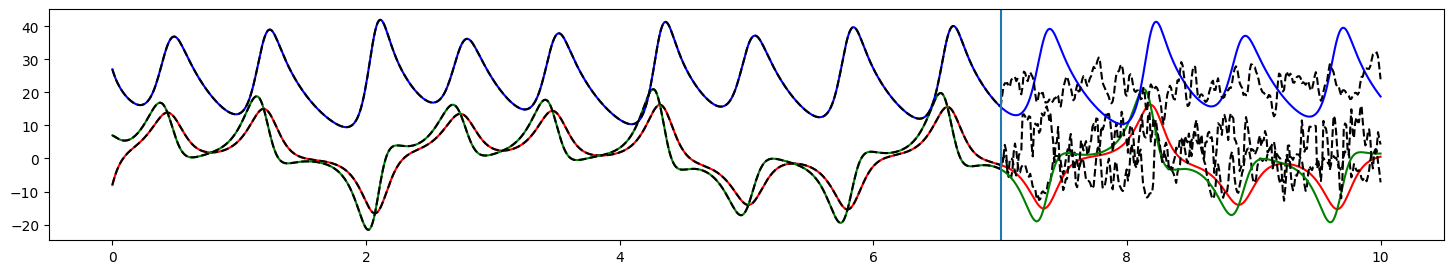

Step 14000, Total loss 0.000006, loss on grad 154127.359375


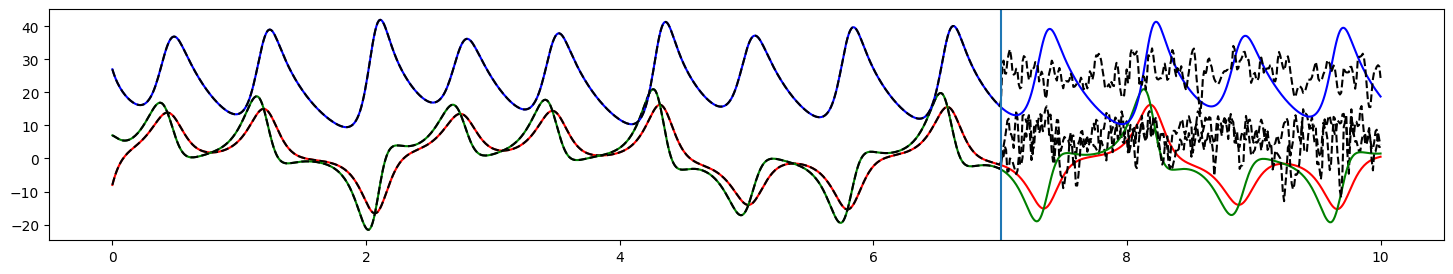

Step 16000, Total loss 0.000000, loss on grad 100665.250000


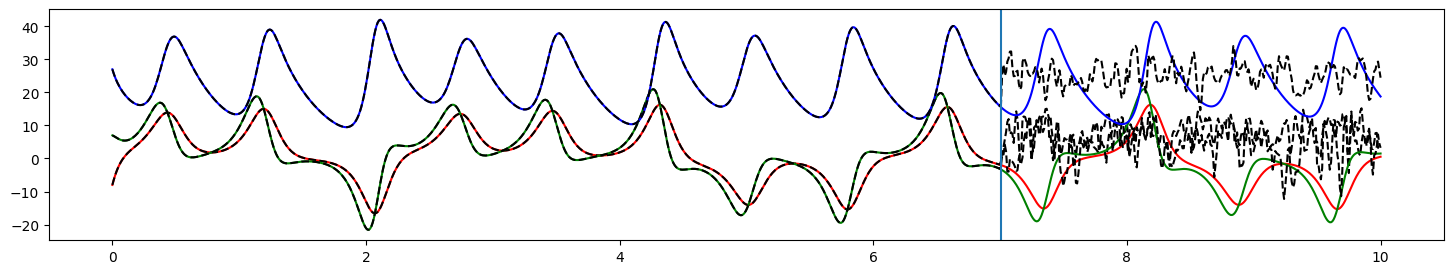

Step 18000, Total loss 0.002116, loss on grad 445787.250000


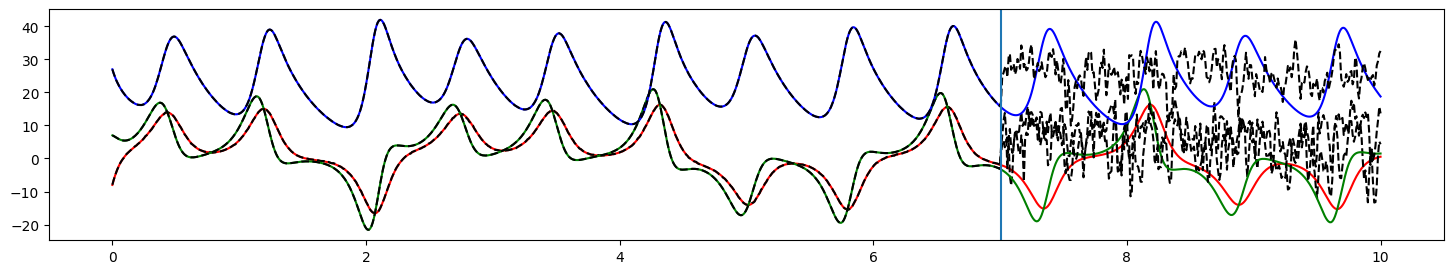

In [9]:
# training
w = 1.0    # [pure state variable measurements] 1.0 --> 0.0 [pure derivative data]
train_with_real_derivative = True  # do we want to use real derivatives or relative relations?
total_steps = 20000
steps_til_summary = 2000

optim = torch.optim.Adam(lr=1e-4, params=list(x.parameters())+list(y.parameters())+list(z.parameters()))

for step in range(total_steps):
    # compute essential quantities
    sampled_xs, t1s = x(torch.tensor(train_ts).view(-1, 1).float().cuda())
    sampled_ys, t2s = y(torch.tensor(train_ts).view(-1, 1).float().cuda())
    sampled_zs, t3s = z(torch.tensor(train_ts).view(-1, 1).float().cuda())
    x_grads = gradient(sampled_xs, t1s)
    y_grads = gradient(sampled_ys, t2s)
    z_grads = gradient(sampled_zs, t3s)
    # compute loss
    state_loss = F.mse_loss(torch.cat([sampled_xs, sampled_ys, sampled_zs], dim=-1), torch.tensor(train_data).float().cuda())
    if train_with_real_derivative:
      # use real derivatives
      dx_loss = F.mse_loss(x_grads, torch.tensor(x_grads_true).view(-1, 1).float().cuda())
      dy_loss = F.mse_loss(y_grads, torch.tensor(y_grads_true).view(-1, 1).float().cuda())
      dz_loss = F.mse_loss(z_grads, torch.tensor(z_grads_true).view(-1, 1).float().cuda())
    else:
      # otherwise use constraints
      dx_loss = F.mse_loss(x_grads, sigma*(sampled_ys - sampled_xs))
      dy_loss = F.mse_loss(y_grads, sampled_xs*(rho - sampled_zs) - sampled_ys)
      dz_loss = F.mse_loss(z_grads , sampled_xs*sampled_ys - beta*sampled_zs)

    grad_loss = dx_loss + dy_loss + dz_loss
    loss = w * state_loss + (1 - w) * grad_loss

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f, loss on grad %0.6f" % (step, loss, grad_loss))
        # plot learned solution
        plt.figure(figsize=(18, 3))
        px = x(torch.tensor(ts).view(-1, 1).float().cuda())[0].detach().cpu().numpy()
        py = y(torch.tensor(ts).view(-1, 1).float().cuda())[0].detach().cpu().numpy()
        pz = z(torch.tensor(ts).view(-1, 1).float().cuda())[0].detach().cpu().numpy()
        plt.plot(ts, data[:, 0], 'r-', ts, px, 'k--')
        plt.plot(ts, data[:, 1], 'g-', ts, py, 'k--')
        plt.plot(ts, data[:, 2], 'b-', ts, pz, 'k--')
        plt.axvline(x=ts[ntrain])
        plt.show()
    # back-prop
    optim.zero_grad()
    loss.backward()
    optim.step()

##Explicación:

Este código sirve para simular el sistema Lorenz, calcular las derivadas exactas (gradientes) de sus variables, y preparar los datos para su uso en modelos de aprendizaje automático o análisis dinámico. El código genera datos que pueden ser utilizados para entrenar un modelo para aprender o predecir la dinámica de sistemas caóticos, comparando predicciones con las gradientes exactas calculadas por las ecuaciones del sistema.